In [1]:
!git clone https://github.com/anupamhap/mb.git

Cloning into 'mb'...
remote: Counting objects: 264, done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 264 (delta 112), reused 244 (delta 96), pack-reused 0
Receiving objects: 100% (264/264), 22.29 MiB | 37.54 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [2]:
!pwd

/content


In [8]:
import os
os.chdir("Tree_Root_Detection")

In [9]:
!ls

classifiers	   Selection_108.jpg  Selection_113.jpg
data		   Selection_109.jpg  test_image2.png
helper.py	   Selection_110.jpg  test_images
__pycache__	   Selection_111.jpg  tree_root_intrusion_detection.ipynb
Selection_107.jpg  Selection_112.jpg  videos


In [67]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn


Using TensorFlow backend.


40


In [41]:
width = 58
height = 58

images = []


In [42]:
roots   = glob.glob('data/tree/*.JPG')
non_roots   = glob.glob('data/non_tree/*.JPG')
non_roots   += glob.glob('data/non_tree/*.jpg')
print(len(roots), len(non_roots))

51 52


In [43]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (5,5), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)


In [44]:
X_train_aug_roots = []
y_train_aug = []

def create_data(n=10):
   for i in range(len(roots)):
       img=mpimg.imread(roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(1)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(1)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(10)

Total number of images in the augmented dataset =  561


In [45]:
def create_data(n=10):
   for i in range(len(non_roots)):
       img=mpimg.imread(non_roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(0)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(0)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(10)

Total number of images in the augmented dataset =  1133


In [46]:
print((y_train_aug))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [56]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.6))
#     seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [57]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence


images, labels = shuffle(X_train_aug_roots, y_train_aug)

In [58]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype)
print(type(images))
print(labels)

uint8
<class 'numpy.ndarray'>
[1 0 0 ... 0 0 0]


In [59]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 2, 2, 64)          27712     
__________

In [61]:

keras_model.fit(images, labels, epochs=30, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 906 samples, validate on 227 samples
Epoch 1/30
906/906 [==============================] - 2s 2ms/step - loss: 0.3960 - acc: 0.8620 - val_loss: 0.3102 - val_acc: 0.8987
Epoch 2/30
906/906 [==============================] - 3s 3ms/step - loss: 0.3226 - acc: 0.8830 - val_loss: 0.2632 - val_acc: 0.9207
Epoch 3/30
906/906 [==============================] - 3s 3ms/step - loss: 0.2607 - acc: 0.9172 - val_loss: 0.3547 - val_acc: 0.8590
Epoch 4/30
906/906 [==============================] - 3s 3ms/step - loss: 0.2680 - acc: 0.8974 - val_loss: 0.2375 - val_acc: 0.9163
Epoch 5/30
906/906 [==============================] - 3s 3ms/step - loss: 0.2380 - acc: 0.9150 - val_loss: 0.2038 - val_acc: 0.9339
Epoch 6/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1939 - acc: 0.9349 - val_loss: 0.3359 - val_acc: 0.8855
Epoch 7/30
320/906 [=========>....................] - ETA: 1s - loss: 0.2653 - acc: 0.9062

906/906 [==============================] - 3s 3ms/step - loss: 0.2155 - acc: 0.9283 - val_loss: 0.2927 - val_acc: 0.8943
Epoch 8/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1870 - acc: 0.9272 - val_loss: 0.3228 - val_acc: 0.8855
Epoch 9/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1786 - acc: 0.9404 - val_loss: 0.1640 - val_acc: 0.9515
Epoch 10/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1462 - acc: 0.9437 - val_loss: 0.3484 - val_acc: 0.8943
Epoch 11/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1658 - acc: 0.9437 - val_loss: 0.3127 - val_acc: 0.8987
Epoch 12/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1414 - acc: 0.9558 - val_loss: 0.1515 - val_acc: 0.9559
Epoch 13/30
864/906 [===========================>..] - ETA: 0s - loss: 0.1125 - acc: 0.9641

906/906 [==============================] - 3s 3ms/step - loss: 0.1125 - acc: 0.9647 - val_loss: 0.1518 - val_acc: 0.9604
Epoch 14/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1293 - acc: 0.9570 - val_loss: 0.2300 - val_acc: 0.9339
Epoch 15/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0919 - acc: 0.9691 - val_loss: 0.1704 - val_acc: 0.9559
Epoch 16/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1593 - acc: 0.9514 - val_loss: 0.1371 - val_acc: 0.9648
Epoch 17/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1062 - acc: 0.9636 - val_loss: 0.1710 - val_acc: 0.9559
Epoch 18/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0848 - acc: 0.9713 - val_loss: 0.1735 - val_acc: 0.9559
Epoch 19/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0866 - acc: 0.9757 - val_loss: 0.1857 - val_acc: 0.9559
Epoch 20/30
 32/906 [>.............................] - ETA: 2s - loss: 0.0128 - a

906/906 [==============================] - 3s 3ms/step - loss: 0.0760 - acc: 0.9757 - val_loss: 0.1676 - val_acc: 0.9604
Epoch 21/30
906/906 [==============================] - 3s 3ms/step - loss: 0.1051 - acc: 0.9647 - val_loss: 0.1596 - val_acc: 0.9559
Epoch 22/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0840 - acc: 0.9735 - val_loss: 0.1590 - val_acc: 0.9559
Epoch 23/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0694 - acc: 0.9801 - val_loss: 0.1672 - val_acc: 0.9604
Epoch 24/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0748 - acc: 0.9790 - val_loss: 0.1909 - val_acc: 0.9559
Epoch 25/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0678 - acc: 0.9812 - val_loss: 0.1598 - val_acc: 0.9604
Epoch 26/30
864/906 [===========================>..] - ETA: 0s - loss: 0.0748 - acc: 0.9780

906/906 [==============================] - 3s 3ms/step - loss: 0.0734 - acc: 0.9790 - val_loss: 0.1659 - val_acc: 0.9648
Epoch 27/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0828 - acc: 0.9757 - val_loss: 0.1411 - val_acc: 0.9648
Epoch 28/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0854 - acc: 0.9702 - val_loss: 0.2135 - val_acc: 0.9427
Epoch 29/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0691 - acc: 0.9823 - val_loss: 0.1968 - val_acc: 0.9427
Epoch 30/30
906/906 [==============================] - 3s 3ms/step - loss: 0.0746 - acc: 0.9801 - val_loss: 0.1725 - val_acc: 0.9604


In [68]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [69]:
save_keras_model(keras_model, 'keras')

In [70]:
!ls

classifiers	 Selection_107.jpg  Selection_113.jpg
data		 Selection_108.jpg  test_image2.png
helper.py	 Selection_109.jpg  test_images
kerasmodel.h5	 Selection_110.jpg  tree_root_intrusion_detection.ipynb
kerasmodel.json  Selection_111.jpg  videos
__pycache__	 Selection_112.jpg


# New Section

In [71]:
from google.colab import files


files.download('kerasmodel.h5')
files.download('kerasmodel.json')


In [0]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [89]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            plt.imshow(subimg)
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(images[800], 0))[0, 0])
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [80]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

test_images/treeroot.JPG


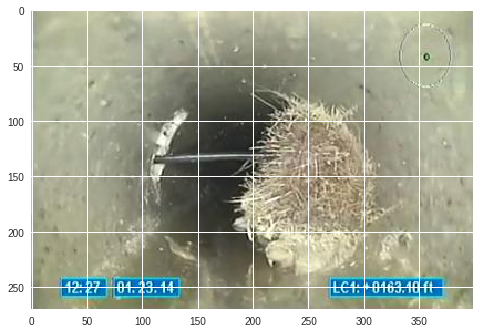

In [95]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 270
scale = 4
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('test_images/*.JPG')

for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    #print(boxes[0][0])
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

In [77]:
!ls

classifiers	 Selection_107.jpg  Selection_113.jpg
data		 Selection_108.jpg  test_image2.png
helper.py	 Selection_109.jpg  test_images
kerasmodel.h5	 Selection_110.jpg  tree_root_intrusion_detection.ipynb
kerasmodel.json  Selection_111.jpg  videos
__pycache__	 Selection_112.jpg
